In [1]:
from captcha.image import ImageCaptcha
from matplotlib import pyplot as plt
import glob
import numpy as np
import random
import os
import string
from PIL import Image 
import time
import tensorflow as tf
%matplotlib inline


In [2]:
#image = ImageCaptcha(fonts=['./font/AntykwaBold.ttf', './font/Candice.ttf', './font/VeraMono.ttf', './font/verdana.ttf'])

# %%timeit
# X = []
# for i in range(1000):
#     text = ''.join(random.sample(char_map, 4))
#     img = np.array(image.generate_image(text).resize((100, 40)))
#     img_gray = np.mean(img, -1)
#     if not isinstance(X, np.ndarray):
#         X = img_gray[..., np.newaxis]
#     else:
#         X = np.concatenate((X, img_gray[..., np.newaxis]), axis=-1)
#     #灰度值求解
#     #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
#     if i % 100 == 0:
#         print("generating captcha " , i)

num_char = 4
num_images_train = 10000
num_images_test = 1000
width_images = 100
height_images = 40
num_charmap = 36
num_channel = 1
char_map = string.ascii_uppercase + string.digits



image_generator = ImageCaptcha(fonts=['./font/AntykwaBold.ttf'])

def dataset_generator(num_images):
    X = np.empty((num_images, height_images, width_images))
    y = np.empty((num_images, num_charmap*num_char))
    for i in range(num_images):
        text = ''.join(random.sample(char_map, num_char))
        img = np.array(image_generator.generate_image(text).resize((width_images, height_images)))
        img_gray = np.mean(img, -1)
        img_scale = np.multiply(img_gray, 1/255.0)
        X[i, :, :] = img_scale
        y_index = [ char_map.find(text[_i])+_i*num_charmap for _i in range(num_char)]
        y[i, y_index] = 1

        #灰度值求解
        #np.sum(np.array([0.2989, 0.5870, 0.1140]) * img, axis=2)
        if (i+1) % (num_images/5) == 0:
            print("generating captcha " , i)
    return X, y

print("generate train dataset: \n", '-'*40)
X_train, y_train = dataset_generator(num_images_train)
print("generate test dataset: \n", '-'*40)
X_test, y_test = dataset_generator(num_images_test)
y_test = np.reshape(y_test, [-1, num_char, num_charmap])        
def generator(X, y, batch_size=100):
    index_in_epoch = 0
    num_images = X.shape[0]
    while True:
        start = index_in_epoch
        index_in_epoch += batch_size
        if index_in_epoch > num_images:
            perm = np.arange(num_images)
            np.random.shuffle(perm)
            X = X[perm]
            y = y[perm]
            start = 0
            index_in_epoch = batch_size
            assert batch_size <= num_images
        end = index_in_epoch
        yield X[start:end], y[start:end]     



generate train dataset: 
 ----------------------------------------
generating captcha  1999
generating captcha  3999
generating captcha  5999
generating captcha  7999
generating captcha  9999
generate test dataset: 
 ----------------------------------------
generating captcha  199
generating captcha  399
generating captcha  599
generating captcha  799
generating captcha  999


In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, [None, height_images, width_images])
y_ = tf.placeholder(tf.float32, [None, num_char, num_charmap])

#todo: find out why reshape doesn.t work
x_image = tf.reshape(x, [-1, height_images, width_images, 1])
# y_ = tf.reshape(y_, [-1, num_char, num_charmap])

#Dropout
keep_prob = tf.placeholder(tf.float32)


#First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

#Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

#Third Convolutional Layer
# W_conv3 = weight_variable([5, 5, 64, 128])
# b_conv3 = bias_variable([128])
# h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_pool3 = max_pool_2x2(h_conv2)

#First densely Connected Layer
W_fc1 = weight_variable([10 * 25 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 10*25*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Readout Layer
W_fc2 = weight_variable([1024, 144])
b_fc2 = bias_variable([144])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#cross_entropy_1 无法导向正确结果，废弃
#cross_entropy_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
#分别计算每个char的softmax损失函数，取其平均值作为整体的损失函数


y_conv = tf.reshape(y_conv, [-1, num_char, num_charmap])

cross_entropy = tf.reduce_mean(tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(y_conv[:, _i ,:], y_[:, _i,:]) 
                  for _i in range(num_char) ]))

# cross_entropy = tf.reduce_mean(
#     tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
#         y_conv[:, num_charmap*i:num_charmap*(i+1)-1], y_[:, num_charmap*i:num_charmap*(i+1)-1]) 
#                   for i in range(num_char) ]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
max_idx_p = tf.argmax(y_conv, 2)
max_idx_l = tf.argmax(y_, 2)
correct_prediction = tf.cast(tf.equal(max_idx_p, max_idx_l), tf.float32)
accuracy = tf.reduce_mean(tf.reduce_min(correct_prediction, axis=1))


In [7]:
#training
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
y_test = np.reshape(y_test, [-1, num_char, num_charmap])
trainset_ge = generator(X_train, y_train, batch_size=128)
num_loop = 20000
print(time.ctime() ,": train cnn begin, amount %d steps"%num_loop)
for i in range(num_loop):
    X_batch, y_batch = next(trainset_ge)
    y_batch = y_batch.reshape(-1, num_char, num_charmap)
    if (i+1)%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:X_batch, y_: y_batch, keep_prob: 1.0})
        print(time.ctime() ,": step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

print(time.ctime() ,": test accuracy %g"%accuracy.eval(feed_dict={
    x: X_test, y_: y_test, keep_prob: 1.0}))

Thu Jan  5 19:49:39 2017 : train cnn begin, amount 20000 steps
Thu Jan  5 19:53:09 2017 : step 99, training accuracy 0
Thu Jan  5 19:56:43 2017 : step 199, training accuracy 0
Thu Jan  5 20:00:41 2017 : step 299, training accuracy 0
Thu Jan  5 20:04:32 2017 : step 399, training accuracy 0
Thu Jan  5 20:08:23 2017 : step 499, training accuracy 0
Thu Jan  5 20:12:11 2017 : step 599, training accuracy 0
Thu Jan  5 20:16:04 2017 : step 699, training accuracy 0
Thu Jan  5 20:20:05 2017 : step 799, training accuracy 0
Thu Jan  5 20:24:05 2017 : step 899, training accuracy 0
Thu Jan  5 20:28:01 2017 : step 999, training accuracy 0
Thu Jan  5 20:32:02 2017 : step 1099, training accuracy 0
Thu Jan  5 20:35:41 2017 : step 1199, training accuracy 0
Thu Jan  5 20:39:36 2017 : step 1299, training accuracy 0
Thu Jan  5 20:43:36 2017 : step 1399, training accuracy 0
Thu Jan  5 20:47:39 2017 : step 1499, training accuracy 0
Thu Jan  5 20:51:36 2017 : step 1599, training accuracy 0
Thu Jan  5 20:55:15 

KeyboardInterrupt: 

In [19]:
saver = tf.train.Saver()
saver.save(sess, "./model/capcha.model", global_step=i)


'./model/capcha.model-5593'

In [5]:
# go on training
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "./model/capcha.model")
y_test = np.reshape(y_test, [-1, num_char, num_charmap])
trainset_ge = generator(X_train, y_train, batch_size=128)
num_loop = 20000
print(time.ctime() ,": train cnn begin, amount %d steps"%num_loop)
for i in range(num_loop):
    X_batch, y_batch = next(trainset_ge)
    y_batch = y_batch.reshape(-1, num_char, num_charmap)
    if (i+1)%100 == 0:
        train_accuracy = accuracy.eval(feed_dict={x:X_batch, y_: y_batch, keep_prob: 1.0})
        print(time.ctime() ,": step %d, training accuracy %g"%(i, train_accuracy))
    train_step.run(feed_dict={x: X_batch, y_: y_batch, keep_prob: 0.5})

Fri Jan  6 12:15:35 2017 : train cnn begin, amount 20000 steps
Fri Jan  6 12:20:14 2017 : step 99, training accuracy 0
Fri Jan  6 12:24:52 2017 : step 199, training accuracy 0.015625
Fri Jan  6 12:29:28 2017 : step 299, training accuracy 0.015625
Fri Jan  6 12:34:05 2017 : step 399, training accuracy 0.03125
Fri Jan  6 12:38:43 2017 : step 499, training accuracy 0.0078125
Fri Jan  6 12:43:22 2017 : step 599, training accuracy 0.046875
Fri Jan  6 12:48:00 2017 : step 699, training accuracy 0.0390625
Fri Jan  6 12:52:37 2017 : step 799, training accuracy 0.101562
Fri Jan  6 12:57:12 2017 : step 899, training accuracy 0.0859375
Fri Jan  6 13:01:47 2017 : step 999, training accuracy 0.15625
Fri Jan  6 13:06:22 2017 : step 1099, training accuracy 0.148438
Fri Jan  6 13:10:57 2017 : step 1199, training accuracy 0.234375
Fri Jan  6 13:15:33 2017 : step 1299, training accuracy 0.234375
Fri Jan  6 13:20:08 2017 : step 1399, training accuracy 0.234375
Fri Jan  6 13:24:43 2017 : step 1499, traini

KeyboardInterrupt: 

In [7]:
print(time.ctime() ,": test accuracy %g"%accuracy.eval(feed_dict={
    x: X_batch, y_: y_batch, keep_prob: 1.0}))

NameError: name 'X_batch' is not defined

['2', 'T', 'R', '8']
['9', 'M', 'O', 'Q']
['N', 'O', 'A', '1']
['9', 'O', 'T', '1']
['A', 'S', 'T', 'I']


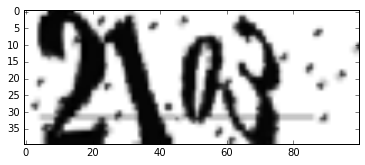

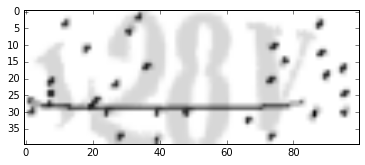

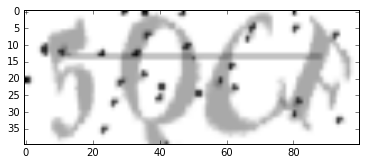

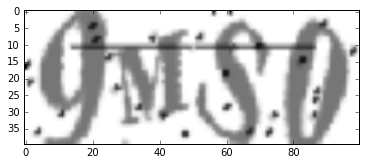

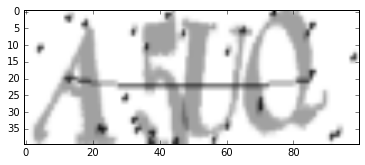

In [8]:
X, y = X_test, y_test
pred = max_idx_p.eval(feed_dict={x:X, keep_prob: 1.0})
idx_lst = range(30,35)
for idx in idx_lst:
    print([char_map[_i] for _i in pred[idx]] )
    plt.figure()
    plt.imshow(X[idx].reshape((40, 100)), cmap='gray')

['3', '8', 'J', 'V']
['D', 'H', 'X', '5']
['Z', 'I', 'P', 'W']
['W', 'X', 'Y', '3']
['C', '5', 'R', 'N']


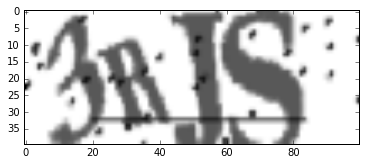

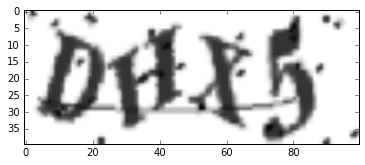

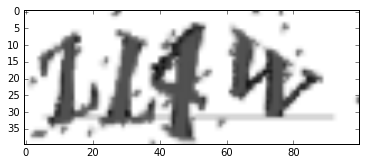

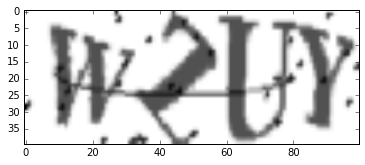

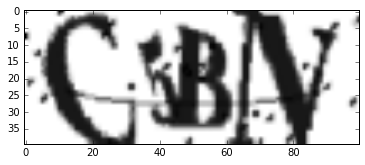

In [18]:
#drop out after conv layer

def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

x = tf.placeholder(tf.float32, [None, height_images, width_images])
y_ = tf.placeholder(tf.float32, [None, num_char, num_charmap])

#todo: find out why reshape doesn.t work
x_image = tf.reshape(x, [-1, height_images, width_images, 1])
# y_ = tf.reshape(y_, [-1, num_char, num_charmap])

#Dropout
keep_prob = tf.placeholder(tf.float32)


#First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)
h_pool1_drop = tf.nn.dropout(h_pool1, keep_prob)

#Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])
h_conv2 = tf.nn.relu(conv2d(h_pool1_drop, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)
h_pool2_drop = tf.nn.dropout(h_pool2, keep_prob)

#Third Convolutional Layer
# W_conv3 = weight_variable([5, 5, 64, 128])
# b_conv3 = bias_variable([128])
# h_conv3 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
# h_pool3 = max_pool_2x2(h_conv2)

#First densely Connected Layer
W_fc1 = weight_variable([10 * 25 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2_drop, [-1, 10*25*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

#Readout Layer
W_fc2 = weight_variable([1024, 144])
b_fc2 = bias_variable([144])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

#cross_entropy_1 无法导向正确结果，废弃
#cross_entropy_1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(y_conv, y_))
#分别计算每个char的softmax损失函数，取其平均值作为整体的损失函数


y_conv = tf.reshape(y_conv, [-1, num_char, num_charmap])

cross_entropy = tf.reduce_mean(tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(y_conv[:, _i ,:], y_[:, _i,:]) 
                  for _i in range(num_char) ]))

# cross_entropy = tf.reduce_mean(
#     tf.concat(0, [tf.nn.softmax_cross_entropy_with_logits(
#         y_conv[:, num_charmap*i:num_charmap*(i+1)-1], y_[:, num_charmap*i:num_charmap*(i+1)-1]) 
#                   for i in range(num_char) ]))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)
max_idx_p = tf.argmax(y_conv, 2)
max_idx_l = tf.argmax(y_, 2)
correct_prediction = tf.cast(tf.equal(max_idx_p, max_idx_l), tf.float32)
accuracy = tf.reduce_mean(tf.reduce_min(correct_prediction, axis=1))



In [5]:
sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "./model/capcha.model")

In [35]:
sess.close()

In [22]:
accuracy.eval(feed_dict={x:X_batch, y_: y_batch, keep_prob: 1.0})

0.2265625

In [39]:
sess.run(tf.global_variables_initializer())

In [19]:
sess.run(tf.global_variables_initializer())